In [51]:
# Imports

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

from typing import List
from typing_extensions import Annotated

import os

In [52]:
# Data Reading

df = pd.read_excel("../data/Registro Público de Emissões.xlsx")

# Data Processing

df = df[df["Escopo"] == "Total"]
df.drop(columns=["Setor da Indústria", "Escopo"], inplace=True)

df = df.transpose()
df.columns = df.iloc[0]
df = df[1:].reset_index()
df = df.rename(columns={"index": "Years"})

list_of_companies = df.columns
list_of_companies = np.array(list_of_companies)
list_of_companies = np.sort(list_of_companies)

values_to_remove = ["Years", "CSN", "ISA Energia"]
mask = ~np.isin(list_of_companies, values_to_remove)
list_of_companies = list_of_companies[mask]

for col in list_of_companies:
    df[col] = df[col].astype(float)
    df[col] = df[col].astype(float)

df.iloc[:, 1:] = df.iloc[:, 1:]/1e6

common_year = 2017
df_filtered = df[df.Years >= common_year]

display(df.head())
display(df.info())

Empresa,Years,Suzano,CSN,Intercement,Ternium Brasil,Votorantim,ArcelorMittal,CBA,ISA Energia
0,2008,1.071559,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,0.734910,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,1.050929,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011,1.369238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012,1.355714,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Years           16 non-null     int64  
 1   Suzano          16 non-null     float64
 2   CSN             11 non-null     object 
 3   Intercement     11 non-null     float64
 4   Ternium Brasil  11 non-null     float64
 5   Votorantim      9 non-null      float64
 6   ArcelorMittal   7 non-null      float64
 7   CBA             7 non-null      float64
 8   ISA Energia     7 non-null      object 
dtypes: float64(6), int64(1), object(2)
memory usage: 1.3+ KB


None

In [53]:
# Auxiliaries Function


def applies_linear_descent_model(X, y, X_pred):
    X_last = X[-1]
    y_last = y[-1]
    y_pred = y_last - ((0.091 * y_last) / (2030 - X_last)) * (X_pred - X_last)
    return y_pred


def applies_linear_regression(X, y, X_pred):
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    y_pred = model.predict(X_pred.reshape(-1, 1))
    y_pred[y_pred < 0] = 0
    return y_pred


def get_rolling_values(df, company_name, windows=2):
    X_train = df.Years.values
    ser = df.loc[:, company_name]

    X_train = df.Years.values[~np.isnan(ser.values)]
    ser = ser[~np.isnan(ser.values)]

    ser = ser.rolling(windows).mean()

    X_rolling = X_train
    y_rolling = ser.values

    X_rolling = X_train[~np.isnan(y_rolling)]
    y_rolling = y_rolling[~np.isnan(y_rolling)]

    return X_rolling, y_rolling


def applies_rolling(y_rolling, X_pred):
    y_pred = np.ones(len(X_pred))
    y_pred *= y_rolling[-1]
    return y_pred


def get_values(df, company_name):
    X_plot = df.Years.values
    y_plot = df.loc[:, company_name].values
    X_plot = X_plot[~np.isnan(y_plot)]
    y_plot = y_plot[~np.isnan(y_plot)]

    return X_plot, y_plot


def set_weights(data, w: list, commom_range_delimiter=5):
    """Set weights for weighted regression."""

    weights = np.ones(len(data))

    weights[:commom_range_delimiter] = w[0]  # past window weight
    weights[commom_range_delimiter:] = w[1]  # common window weight

    return weights


def generate_weight_pairs_matrix(weight_a, weight_b, n):
    """Generate matrix with weight lists [wa, wb], such that wa + wb = 1 for tests."""

    # Matrix Columns
    col2 = np.linspace(weight_a, weight_b, n)
    col1 = 1 - col2

    # Matrix
    weight_pairs = np.column_stack((col1, col2))

    return weight_pairs


def fit_model(
    X,
    y,
    model: str,
    weights: Annotated[List[float], "List of past- and common-windou weights [wp, wc]"],
    commom_range_delimiter,
):
    """Select models for weighted regression."""

    # Weights
    weights = set_weights(y, weights, commom_range_delimiter)

    # Reshape Input for 2D
    X = X.reshape(-1, 1)

    if model == "poly":
        M = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
        M.fit(X, y, linearregression__sample_weight=weights)

    elif model == "svr-rbf":
        M = make_pipeline(StandardScaler(), SVR(kernel="rbf"))
        M = SVR(kernel="rbf")
        M.fit(X, y, sample_weight=weights)

    elif model == "svr-poly":
        M = SVR(kernel="poly")
        M.fit(X, y, sample_weight=weights)

    elif model == "rf":
        M = RandomForestRegressor(n_estimators=100)
        M.fit(X, y, sample_weight=weights)

    return M

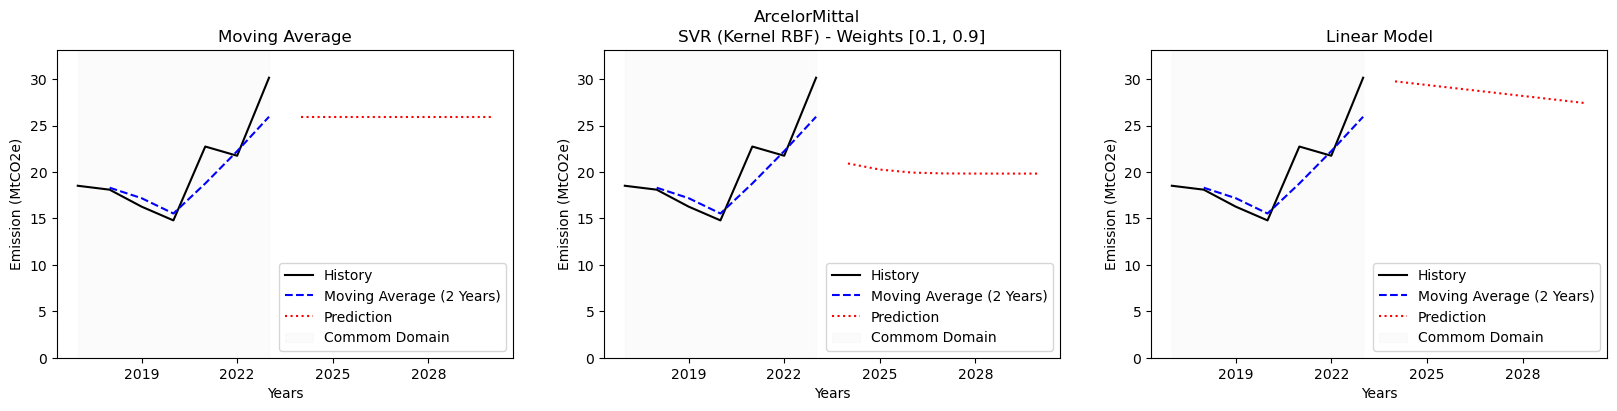

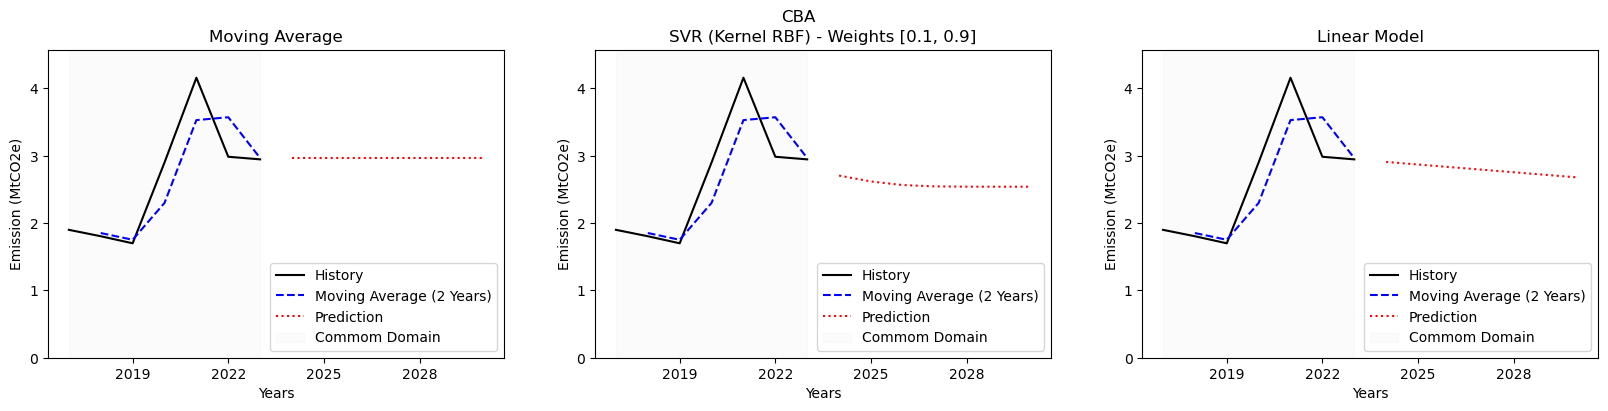

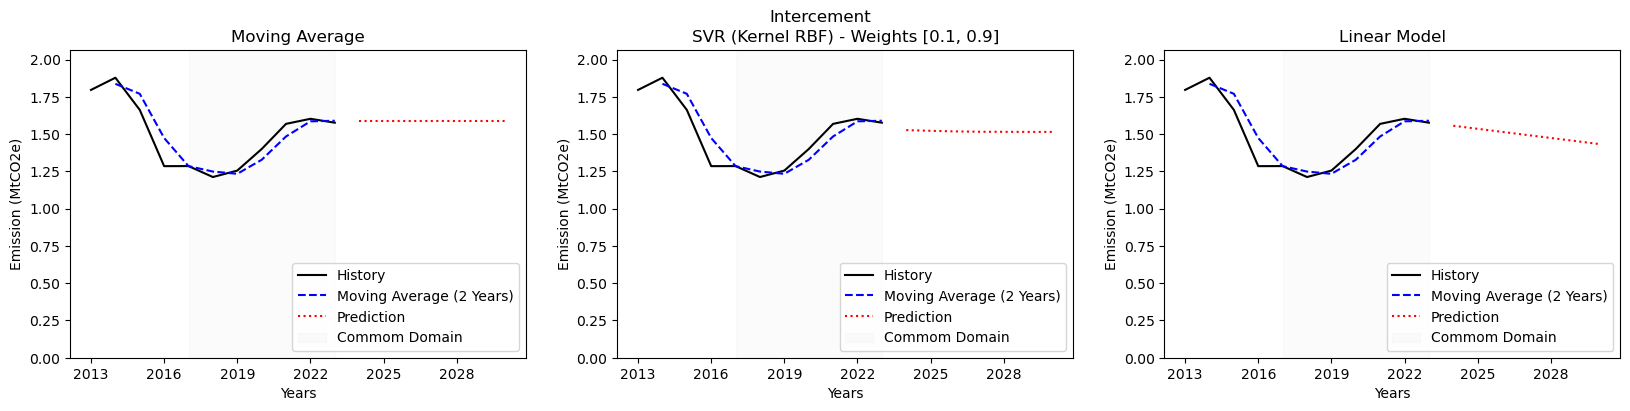

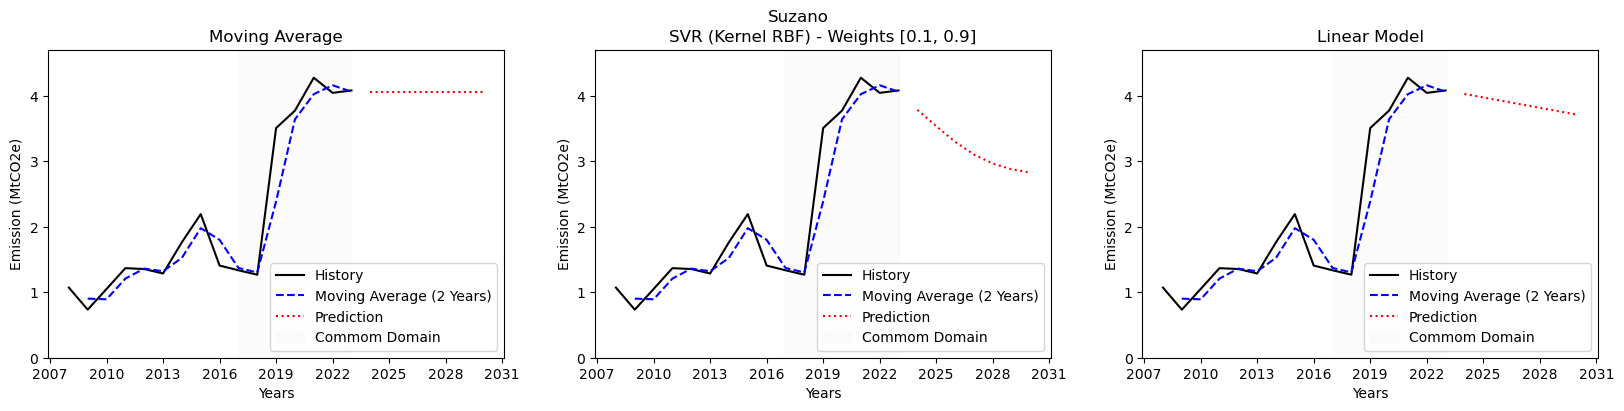

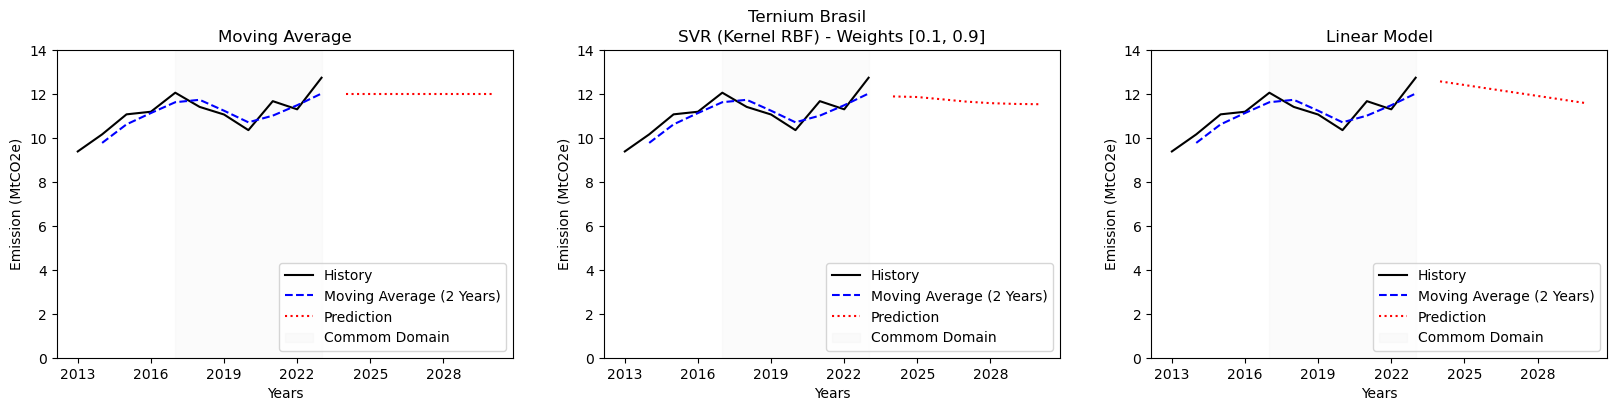

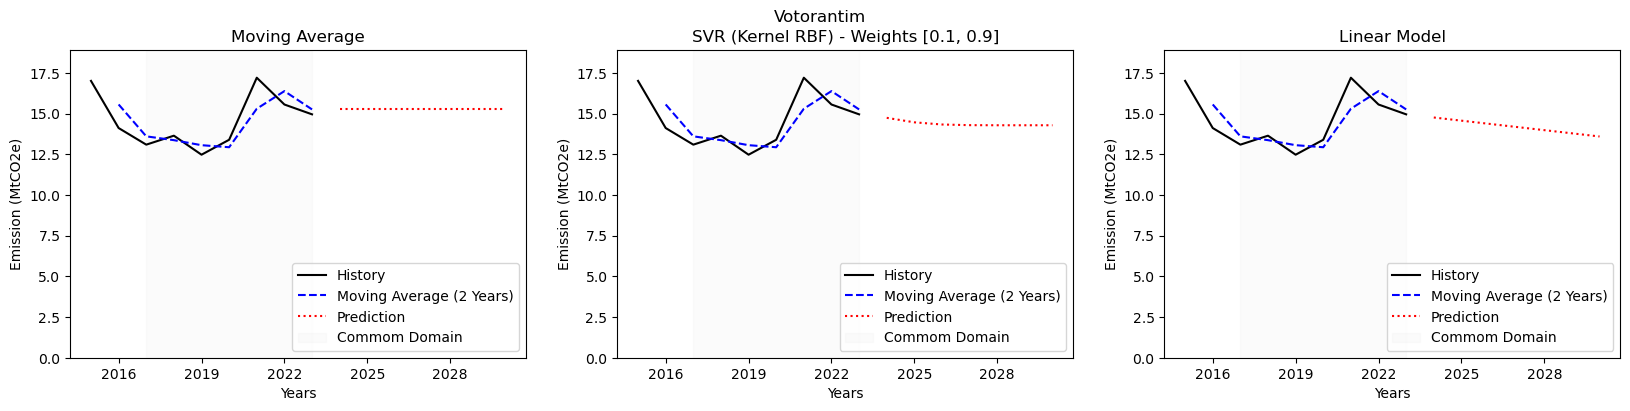

In [54]:
# Execution

X_pred = np.array(range(2024, 2031))
commom_range = [2017, 2023]
weights = [0.1, 0.9]
windows = 2

output = dict()
output["Years"] = X_pred.tolist()

for company_name in list_of_companies:
    X_train, y_train = get_values(df, company_name)
    X_filtered, y_filtered = get_values(df_filtered, company_name)
    X_rolling, y_rolling = get_rolling_values(df, company_name, windows=windows)
    commom_range_delimiter = np.where(X_train == common_year)[0][0]

    fig, axs = plt.subplots(1, 3, figsize=(20, 4))
    axs = axs.flatten()

    # Moving Average
    y_pred = applies_rolling(y_rolling, X_pred)

    output[f"{company_name} - Moving Average"] = y_pred.tolist()

    ax = axs[0]
    ax.plot(X_train, y_train, "k", label="History")
    ax.plot(X_rolling, y_rolling, "--b", label="Moving Average (2 Years)")
    ax.plot(X_pred, y_pred, "r:", label="Prediction")
    ax.axvspan(
        commom_range[0],
        commom_range[1],
        color="gray",
        alpha=0.03,
        label="Commom Domain",
    )

    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.set_ylim([0, 1.1 * max(max(y_train), max(y_pred))])
    ax.legend(loc="lower right")
    ax.set_xlabel("Years")
    ax.set_ylabel("Emission (MtCO2e)")
    ax.set_title(f"Moving Average")

    # SVR Model
    model = "svr-rbf"
    M = fit_model(X_train, y_train, model, weights, commom_range_delimiter)
    y_pred = M.predict(X_pred.reshape(-1, 1))
    y_pred[y_pred < 0] = 0

    output[f"{company_name} - SVR"] = y_pred.tolist()

    ax = axs[1]
    ax.plot(X_train, y_train, "k", label="History")
    ax.plot(X_rolling, y_rolling, "--b", label="Moving Average (2 Years)")
    ax.plot(X_pred, y_pred, "r:", label="Prediction")
    ax.axvspan(
        commom_range[0],
        commom_range[1],
        color="gray",
        alpha=0.03,
        label="Commom Domain",
    )

    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.set_ylim([0, 1.1 * max(max(y_train), max(y_pred))])
    ax.legend(loc="lower right")
    ax.set_xlabel("Years")
    ax.set_ylabel("Emission (MtCO2e)")
    ax.set_title(f"SVR (Kernel RBF) - Weights [0.1, 0.9]")

    # Linear Model
    y_pred = applies_linear_descent_model(X_filtered, y_filtered, X_pred)

    ax = axs[2]
    ax.plot(X_train, y_train, "k", label="History")
    ax.plot(X_rolling, y_rolling, "--b", label="Moving Average (2 Years)")
    ax.plot(X_pred, y_pred, "r:", label="Prediction")
    ax.axvspan(
        commom_range[0],
        commom_range[1],
        color="gray",
        alpha=0.03,
        label="Commom Domain",
    )

    output[f"{company_name} - Linear"] = y_pred.tolist()

    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.set_ylim([0, 1.1 * max(max(y_train), max(y_pred))])
    ax.legend(loc="lower right")
    ax.set_xlabel("Years")
    ax.set_ylabel("Emission (MtCO2e)")
    ax.set_title(f"Linear Model")

    fig.suptitle(f"{company_name}")
    fig.savefig(f"../img/{company_name}.png")

In [55]:
# Export Values

output = pd.DataFrame(output)
output.to_csv("../data/Forecast (MtCO2e).csv")
output.to_excel("../data/Forecast (MtCO2e).xlsx")
